# ISTAT NIC - Extract NIC Data from Excel

This notebook extracts NIC (Nuclei familiari con Indice dei Consumi) data from the ISTAT Excel file.

**Data source:**
- File: `data/istat/nic_1996_2015.xls`
- Tab: EN
- ECOICOP: 00
- Level: Gen.
- Period: From January 1996 onwards

The notebook extracts the data and saves it to `data/istat/NIC_MONTHLY.csv` with columns:
- TIME_PERIOD: Date period (YYYY-MM format)
- OBS_VALUE: Observation value


In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Change to project root directory
# Find the project root by looking for the 'data' directory
current_dir = os.getcwd()
while not os.path.exists(os.path.join(current_dir, 'data')):
    parent_dir = os.path.dirname(current_dir)
    if parent_dir == current_dir:
        # Reached filesystem root without finding 'data' directory
        raise FileNotFoundError("Could not find project root directory (looking for 'data' folder)")
    current_dir = parent_dir

os.chdir(current_dir)
print(f"Working directory: {os.getcwd()}")

# Define input and output files
input_file = 'data/istat/nic_1996_2015.xls'
output_file = 'data/istat/NIC_MONTHLY.csv'
output_dir = 'data/istat'

# Check that the input file exists
if not os.path.exists(input_file):
    raise FileNotFoundError(f"File not found: {input_file}")

print(f"Input file: {input_file}")
print(f"Output file: {output_file}")


Working directory: /workspace
Input file: data/istat/nic_1996_2015.xls
Output file: data/istat/NIC_MONTHLY.csv


## Read Excel File

Read the Excel file and analyze its structure to find the row with ECOICOP=00 and level=Gen.


In [5]:
# Read the Excel file, specifically the "EN" tab
# Structure: 
# - Row 10 (index 10): Header row with ECOICOP, level, denominations, and monthly dates
# - Row 11 onwards: Data rows with ECOICOP codes, levels, and monthly values in columns
print(f"\n{'='*60}")
print("Reading Excel file structure...")
print(f"{'='*60}")

try:
    # Read the full file without header
    df_full = pd.read_excel(input_file, sheet_name='EN', header=None, engine='xlrd')
    
    print(f"Full data shape: {df_full.shape}")
    
    # Get header row (row 10, index 10)
    header_row = df_full.iloc[10]
    print(f"\nHeader row (row 10, first 15 columns):")
    print(header_row.iloc[:15].tolist())
    
    # Find the row with ECOICOP=00 and level=Gen.
    # This should be row 11 (index 11) based on the structure
    print(f"\n{'='*60}")
    print("Searching for ECOICOP=00 and level=Gen...")
    print(f"{'='*60}")
    
    target_row_idx = None
    for idx in range(11, min(len(df_full), 100)):  # Start from row 11, check first 100 rows
        row = df_full.iloc[idx]
        # Check if first column contains '00' and second column contains 'Gen.'
        first_col = str(row.iloc[0]).strip() if pd.notna(row.iloc[0]) else ''
        second_col = str(row.iloc[1]).strip() if pd.notna(row.iloc[1]) else ''
        
        if first_col == '00' and 'Gen.' in second_col:
            target_row_idx = idx
            print(f"\nFound target row at index {idx}:")
            print(f"  Column 0 (ECOICOP): {first_col}")
            print(f"  Column 1 (level): {second_col}")
            print(f"  Column 2 (description): {row.iloc[2] if pd.notna(row.iloc[2]) else 'N/A'}")
            print(f"  First few values: {row.iloc[3:8].tolist()}")
            break
    
    if target_row_idx is None:
        raise ValueError("Could not find row with ECOICOP=00 and level=Gen.")
    
    print(f"\nTarget row index: {target_row_idx}")
    
except Exception as e:
    print(f"Error reading Excel file: {e}")
    import traceback
    traceback.print_exc()
    raise



Reading Excel file structure...
Full data shape: (339, 243)

Header row (row 10, first 15 columns):
['ECOICOP', 'level', 'denominations 2016', datetime.datetime(1996, 1, 1, 0, 0), datetime.datetime(1996, 2, 1, 0, 0), datetime.datetime(1996, 3, 1, 0, 0), datetime.datetime(1996, 4, 1, 0, 0), datetime.datetime(1996, 5, 1, 0, 0), datetime.datetime(1996, 6, 1, 0, 0), datetime.datetime(1996, 7, 1, 0, 0), datetime.datetime(1996, 8, 1, 0, 0), datetime.datetime(1996, 9, 1, 0, 0), datetime.datetime(1996, 10, 1, 0, 0), datetime.datetime(1996, 11, 1, 0, 0), datetime.datetime(1996, 12, 1, 0, 0)]

Searching for ECOICOP=00 and level=Gen...

Found target row at index 11:
  Column 0 (ECOICOP): 00
  Column 1 (level): Gen.
  Column 2 (description): general index (with tobacco)
  First few values: [68.2, 68.5, 68.7, 69, 69.3]

Target row index: 11


## Extract Data

Extract the data row and identify columns starting from January 1996.


In [6]:
# Extract data from the target row
# The header row (row 10) contains the dates in columns starting from column 3
# The target row contains the values in the same columns
print(f"\n{'='*60}")
print("Extracting data from target row...")
print(f"{'='*60}")

# Get header row (row 10) and target row
header_row = df_full.iloc[10]
target_row = df_full.iloc[target_row_idx]

print(f"Header row (row 10) - first 15 columns:")
print(header_row.iloc[:15].tolist())
print(f"\nTarget row (row {target_row_idx}) - first 15 columns:")
print(target_row.iloc[:15].tolist())

# Extract dates from header row and values from target row
# Dates start from column 3 (index 3)
data_dict = {}
start_col_idx = None

for col_idx in range(3, len(header_row)):  # Start from column 3 (where dates begin)
    # Get date from header row
    date_value = header_row.iloc[col_idx]
    
    if pd.notna(date_value):
        try:
            # Try to parse as date
            date_val = None
            if isinstance(date_value, datetime):
                date_val = date_value
            elif isinstance(date_value, pd.Timestamp):
                date_val = date_value.to_pydatetime()
            else:
                # Try parsing string dates
                date_val = pd.to_datetime(str(date_value), errors='coerce')
                if pd.notna(date_val) and isinstance(date_val, pd.Timestamp):
                    date_val = date_val.to_pydatetime()
            
            if isinstance(date_val, datetime):
                # Check if date is January 1996 or later
                if date_val >= datetime(1996, 1, 1):
                    if start_col_idx is None:
                        start_col_idx = col_idx
                        print(f"\nFound start column at index {col_idx}: {date_val}")
                    
                    # Get value from target row
                    value = target_row.iloc[col_idx]
                    value = pd.to_numeric(value, errors='coerce')
                    
                    if pd.notna(value):
                        date_str = date_val.strftime('%Y-%m')
                        data_dict[date_str] = value
                elif date_val < datetime(1996, 1, 1):
                    # Skip dates before January 1996
                    continue
                    
        except Exception as e:
            # Not a date column or parsing error, skip
            continue

if start_col_idx is None or len(data_dict) == 0:
    raise ValueError("Could not find columns starting from January 1996")

print(f"\nExtracted {len(data_dict)} data points")
print(f"Date range: {min(data_dict.keys())} to {max(data_dict.keys())}")
print(f"\nFirst 10 data points:")
for i, (date, value) in enumerate(sorted(data_dict.items())[:10]):
    print(f"  {date}: {value}")
print(f"\nLast 10 data points:")
for i, (date, value) in enumerate(sorted(data_dict.items())[-10:]):
    print(f"  {date}: {value}")



Extracting data from target row...
Header row (row 10) - first 15 columns:
['ECOICOP', 'level', 'denominations 2016', datetime.datetime(1996, 1, 1, 0, 0), datetime.datetime(1996, 2, 1, 0, 0), datetime.datetime(1996, 3, 1, 0, 0), datetime.datetime(1996, 4, 1, 0, 0), datetime.datetime(1996, 5, 1, 0, 0), datetime.datetime(1996, 6, 1, 0, 0), datetime.datetime(1996, 7, 1, 0, 0), datetime.datetime(1996, 8, 1, 0, 0), datetime.datetime(1996, 9, 1, 0, 0), datetime.datetime(1996, 10, 1, 0, 0), datetime.datetime(1996, 11, 1, 0, 0), datetime.datetime(1996, 12, 1, 0, 0)]

Target row (row 11) - first 15 columns:
['00', 'Gen.', 'general index (with tobacco)', 68.2, 68.5, 68.7, 69, 69.3, 69.4, 69.3, 69.4, 69.5, 69.5, 69.8, 69.9]

Found start column at index 3: 1996-01-01 00:00:00

Extracted 240 data points
Date range: 1996-01 to 2015-12

First 10 data points:
  1996-01: 68.2
  1996-02: 68.5
  1996-03: 68.7
  1996-04: 69
  1996-05: 69.3
  1996-06: 69.4
  1996-07: 69.3
  1996-08: 69.4
  1996-09: 69.5
 

## Create DataFrame and Save to CSV

Create a DataFrame with TIME_PERIOD and OBS_VALUE columns and save to CSV.


In [7]:
# Create DataFrame
print(f"\n{'='*60}")
print("Creating DataFrame...")
print(f"{'='*60}")

# Convert dictionary to DataFrame
df = pd.DataFrame([
    {'TIME_PERIOD': date, 'OBS_VALUE': value}
    for date, value in sorted(data_dict.items())
])

# Ensure OBS_VALUE is numeric
df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')

# Remove rows with missing values
df = df.dropna()

# Sort by TIME_PERIOD
df = df.sort_values(by='TIME_PERIOD').reset_index(drop=True)

print(f"\nDataFrame shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nTime period range: {df['TIME_PERIOD'].min()} to {df['TIME_PERIOD'].max()}")
print(f"\nFirst 20 rows:")
print(df.head(20))
print(f"\nLast 20 rows:")
print(df.tail(20))

# Save to CSV
os.makedirs(output_dir, exist_ok=True)
df.to_csv(output_file, index=False)

print(f"\n{'='*60}")
print(f"File saved successfully: {output_file}")
print(f"Dimensions: {len(df)} rows, {len(df.columns)} columns")
print(f"{'='*60}")



Creating DataFrame...

DataFrame shape: (240, 2)
Columns: ['TIME_PERIOD', 'OBS_VALUE']

Time period range: 1996-01 to 2015-12

First 20 rows:
   TIME_PERIOD  OBS_VALUE
0      1996-01       68.2
1      1996-02       68.5
2      1996-03       68.7
3      1996-04       69.0
4      1996-05       69.3
5      1996-06       69.4
6      1996-07       69.3
7      1996-08       69.4
8      1996-09       69.5
9      1996-10       69.5
10     1996-11       69.8
11     1996-12       69.9
12     1997-01       70.0
13     1997-02       70.1
14     1997-03       70.3
15     1997-04       70.4
16     1997-05       70.6
17     1997-06       70.6
18     1997-07       70.6
19     1997-08       70.7

Last 20 rows:
    TIME_PERIOD  OBS_VALUE
220     2014-05      100.0
221     2014-06      100.1
222     2014-07      100.0
223     2014-08      100.2
224     2014-09       99.8
225     2014-10       99.9
226     2014-11       99.7
227     2014-12       99.7
228     2015-01       99.3
229     2015-02       99.7

## Plot NIC Data

Create a plot to visualize the NIC monthly data series.



Creating plot...

Plot saved: data/istat/NIC_MONTHLY_plot.png


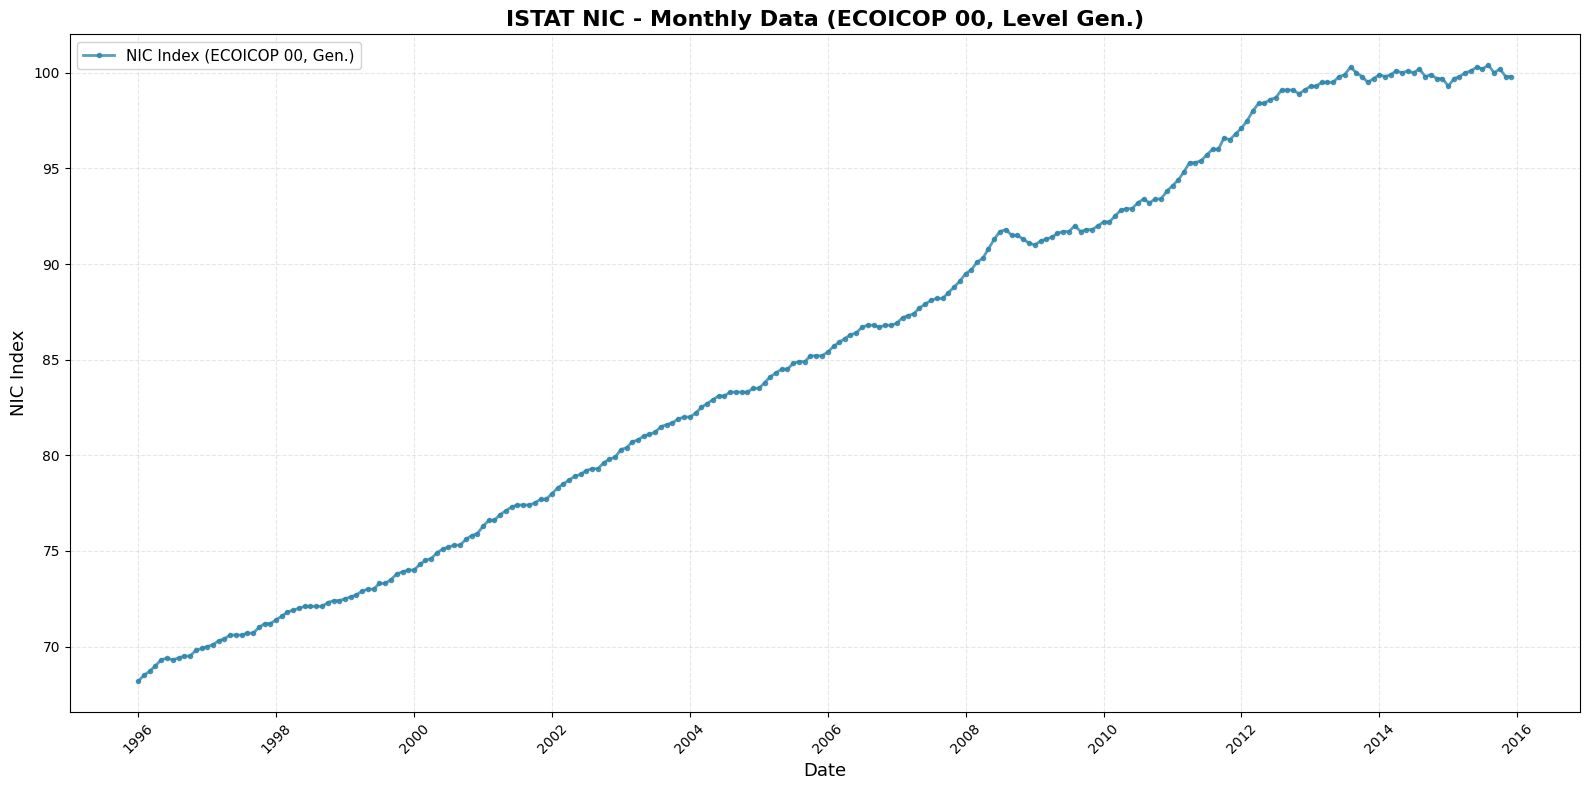


Plot created successfully!


In [8]:
# Create plot
print(f"\n{'='*60}")
print("Creating plot...")
print(f"{'='*60}")

# Convert TIME_PERIOD to datetime for plotting
df['DATE'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y-%m')

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df['DATE'], df['OBS_VALUE'], 
        label='NIC Index (ECOICOP 00, Gen.)', linewidth=2, color='#2E86AB', alpha=0.8, marker='o', markersize=3)

ax.set_title('ISTAT NIC - Monthly Data (ECOICOP 00, Level Gen.)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('NIC Index', fontsize=13)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(2))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()

# Save the plot
plot_file = os.path.join(output_dir, 'NIC_MONTHLY_plot.png')
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(f"\nPlot saved: {plot_file}")

plt.show()

print(f"\n{'='*60}")
print("Plot created successfully!")
print(f"{'='*60}")
